# Create Y and E Arrays from ICD10 Data

This notebook converts a dataframe with patient diagnoses (eid, diag_icd10, age_diag) into:
- **Y array**: Binary array of shape (N, D, T) where Y[n, d, t] = 1 if patient n had disease d at age (30+t)
- **E array**: Exposure/censor array of shape (N, D, T) indicating when patients are at risk

Then computes:
- Max censor replacement
- Corrected E matrix
- Prevalence estimates


In [1]:
# Import the script
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/')
from create_Y_E_from_icd10 import create_Y_E_arrays

import pandas as pd
import numpy as np
import torch
from pathlib import Path

print("Setup complete")


Setup complete


## Step 1: Load ICD10 Data


In [ ]:
# Load ICD10 data
# Format: eid, diag_icd10, age_diag
icd10_path = '/Users/sarahurbut/aladynoulli2/aou_icd10.csv'  # Change for AOU or MGB

df = pd.read_csv(icd10_path)
print(f"Loaded {len(df):,} diagnosis records")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nUnique patients: {df['eid'].nunique():,}")
print(f"Unique diseases: {df['diag_icd10'].nunique():,}")
print(f"Age range: {df['age_diag'].min()} - {df['age_diag'].max()}")


## Step 2: Create Y and E Arrays


In [ ]:
output_dir = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata')

# Use disease order CSV to match original Y_binary.rds order
disease_order_csv = '/Users/sarahurbut/aladynoulli2/aou_diag_names.csv'  # Change for AOU or MGB

results = create_Y_E_arrays(
    df, 
    age_offset=30,
    output_dir=str(output_dir),
    disease_order_csv=disease_order_csv  # This ensures diseases are in the same order as original Y
)

# Extract results
Y = results['Y']
E = results['E']
E_corrected = results['E_corrected']
prevalence_t = results['prevalence_t']
patient_names = results['patient_names']
disease_names = results['disease_names']
max_censor_df = results['max_censor_df']

print(f"\nResults:")
print(f"  Y shape: {Y.shape}")
print(f"  E shape: {E.shape}")
print(f"  E_corrected shape: {E_corrected.shape}")
print(f"  Prevalence shape: {prevalence_t.shape}")
print(f"  Patient names: {len(patient_names)}")
print(f"  Disease names: {len(disease_names)}")


In [ ]:
# ============================================================================
# Recreate E_corrected from existing Y and max_censor_df
# ============================================================================

import numpy as np
import pandas as pd

print("\n" + "="*80)
print("RECREATING E_CORRECTED")
print("="*80)

# Get dimensions
N, D, T = Y.shape
print(f"Y shape: {Y.shape}")
print(f"T (timepoints): {T}")

# Convert Y to numpy if needed
if hasattr(Y, 'numpy'):
    Y_np = Y.numpy()
else:
    Y_np = np.array(Y)

# Step 1: Initialize E_corrected with max censor timepoint (capped at T-1)
print("\nStep 1: Initializing E_corrected with max censor timepoints...")
E_corrected = np.zeros((N, D), dtype=np.int32)

for patient_idx, patient_id in enumerate(patient_names):
    max_age_patient = max_censor_df.loc[max_censor_df['eid'] == patient_id, 'max_censor'].values[0]
    max_timepoint = int(max_age_patient - 30)  # age_offset = 30
    max_timepoint = max(0, min(max_timepoint, T - 1))  # Clip to [0, T-1]
    E_corrected[patient_idx, :] = max_timepoint

print(f"  ✓ Initialized with max censor timepoints")
print(f"    Mean: {E_corrected.mean():.2f}")
print(f"    Range: {E_corrected.min()} - {E_corrected.max()}")

# Step 2: Replace with event timepoint if event occurred earlier
print("\nStep 2: Updating E_corrected for diseases with events...")

event_count = 0
for patient_idx in range(N):
    for disease_idx in range(D):
        # Find first event in Y
        event_timepoints = np.where(Y_np[patient_idx, disease_idx, :] == 1)[0]
        if len(event_timepoints) > 0:
            first_event_timepoint = event_timepoints[0]
            # Only update if event occurred before max censor timepoint
            if first_event_timepoint < E_corrected[patient_idx, disease_idx]:
                E_corrected[patient_idx, disease_idx] = first_event_timepoint
                event_count += 1
    
    if (patient_idx + 1) % 10000 == 0:
        print(f"  Processed {patient_idx + 1:,} / {N:,} patients...")

print(f"  ✓ Updated {event_count:,} disease-patient pairs with events")
print(f"    Mean: {E_corrected.mean():.2f}")
print(f"    Range: {E_corrected.min()} - {E_corrected.max()}")

# Verify no negative values
if E_corrected.min() < 0:
    print(f"\n⚠️ WARNING: Found {np.sum(E_corrected < 0)} negative values!")
    print(f"   Min value: {E_corrected.min()}")
    print(f"   These will be clipped to 0")
    E_corrected = np.clip(E_corrected, 0, T - 1)
else:
    print(f"\n✓ No negative values found")

# Verify no values > T-1
if E_corrected.max() >= T:
    print(f"\n⚠️ WARNING: Found {np.sum(E_corrected >= T)} values >= T!")
    print(f"   Max value: {E_corrected.max()}")
    print(f"   These will be clipped to T-1")
    E_corrected = np.clip(E_corrected, 0, T - 1)

print(f"\n{'='*80}")
print("FINAL E_CORRECTED STATS")
print(f"{'='*80}")
print(f"  Shape: {E_corrected.shape}")
print(f"  Mean: {E_corrected.mean():.2f}")
print(f"  Range: {E_corrected.min()} - {E_corrected.max()}")
print(f"  Patients with events: {(E_corrected < (T - 1)).any(axis=1).sum():,} / {N:,}")
print(f"  Total disease-patient pairs with events: {(E_corrected < (T - 1)).sum():,}")

# Update the results dictionary
results['E_corrected'] = E_corrected

print(f"\n✓ E_corrected recreated successfully!")

In [ ]:
from scipy.ndimage import gaussian_filter1d
    
def compute_smoothed_prevalence_at_risk(Y, E_corrected,  window_size=5, smooth_on_logit=True):
    """Compute smoothed prevalence with proper at-risk filtering."""
    if torch.is_tensor(Y):
        Y = Y.numpy()
    if torch.is_tensor(E_corrected):
        E_corrected = E_corrected.numpy()
    
    N, D, T = Y.shape
    prevalence_t = np.zeros((D, T))
    timepoint_ages = np.arange(T) + 30
    
    print(f"Computing prevalence for {D} diseases, {T} timepoints...")
    
    E_corrected_np = E_corrected.numpy() if torch.is_tensor(E_corrected) else E_corrected
    
    for d in range(D):
        if d % 50 == 0:
            print(f"  Processing disease {d}/{D}...")
        
        for t in range(T):
            at_risk_mask = (E_corrected_np[:, d] >= t)
            
            if at_risk_mask.sum() > 0:
                prevalence_t[d, t] = Y[at_risk_mask, d, t].mean()
            else:
                prevalence_t[d, t] = np.nan
        
        if smooth_on_logit:
            epsilon = 1e-8
            valid_mask = ~np.isnan(prevalence_t[d, :])
            if valid_mask.sum() > 0:
                logit_prev = np.full(T, np.nan)
                logit_prev[valid_mask] = np.log(
                    (prevalence_t[d, valid_mask] + epsilon) / 
                    (1 - prevalence_t[d, valid_mask] + epsilon)
                )
                smoothed_logit = gaussian_filter1d(np.nan_to_num(logit_prev, nan=0), sigma=window_size)
                smoothed_logit[~valid_mask] = np.nan
                prevalence_t[d, :] = 1 / (1 + np.exp(-smoothed_logit))
        else:
            prevalence_t[d, :] = gaussian_filter1d(np.nan_to_num(prevalence_t[d, :], nan=0), sigma=window_size)
    
    return prevalence_t


def create_reference_trajectories(Y_filtered, initial_clusters, K, healthy_prop=0, frac=0.3):
    """Create reference trajectories using LOWESS smoothing on logit scale"""
    T = Y_filtered.shape[2]
    Y_counts = Y_filtered.sum(dim=0)  
    signature_props = torch.zeros(K, T)
    total_counts = Y_counts.sum(dim=0) + 1e-8
    
    for k in range(K):
        cluster_mask = (initial_clusters == k)
        signature_props[k] = Y_counts[cluster_mask].sum(dim=0) / total_counts
    
    signature_props = torch.clamp(signature_props, min=1e-8, max=1-1e-8)
    signature_props = signature_props / signature_props.sum(dim=0, keepdim=True)
    signature_props *= (1 - healthy_prop)
    
    logit_props = torch.tensor(logit(signature_props.numpy()))
    signature_refs = torch.zeros_like(logit_props)
    
    times = np.arange(T)
    for k in range(K):
        smoothed = lowess(logit_props[k].numpy(), times, frac=frac, it=3, delta=0.0, return_sorted=False)
        signature_refs[k] = torch.tensor(smoothed)
    
    healthy_ref = torch.ones(T) * logit(torch.tensor(healthy_prop))
    return signature_refs, healthy_ref


In [ ]:
# Save E_corrected
output_dir = Path('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata')

print("\n" + "="*80)
print("SAVING E_CORRECTED")
print("="*80)

# Convert to tensor and save
E_corrected_tensor = torch.FloatTensor(E_corrected)
torch.save(E_corrected_tensor, output_dir / 'E_corrected.pt')
print(f"✓ Saved E_corrected to: {output_dir / 'E_corrected.pt'}")
print(f"  Shape: {E_corrected.shape}")
print(f"  Dtype: {E_corrected.dtype}")

# Also update results dictionary if you want to save everything
results['E_corrected'] = E_corrected

In [ ]:
prevalence_t = compute_smoothed_prevalence_at_risk(Y,E_corrected)

In [ ]:
torch.save(torch.FloatTensor(prevalence_t), output_dir / 'prevalence_t_corrected.pt')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load prevalence if not already in memory
# prevalence_t = results['prevalence_t']  # or load from file

# Diseases to plot
prevalence_t = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata/prevalence_t_corrected.pt')
disease_indices = [112, 47, 19]
disease_names_list = [disease_names[idx] if idx < len(disease_names) else f"Disease {idx}" 
                      for idx in disease_indices]

# Create figure
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Timepoints (ages)
ages = np.arange(30, 30 + prevalence_t.shape[1])  # age_offset = 30

for i, (disease_idx, disease_name) in enumerate(zip(disease_indices, disease_names_list)):
    ax = axes[i]
    
    # Get prevalence for this disease
    prev = prevalence_t[disease_idx, :]
    
    # Plot
    ax.plot(ages, prev, linewidth=2, marker='o', markersize=3)
    ax.set_xlabel('Age', fontsize=12)
    ax.set_ylabel('Prevalence', fontsize=12)
    ax.set_title(f'Disease {disease_idx}\n{disease_name}', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([30, 81])
    
    # Add stats
    valid_prev = prev[~np.isnan(prev)]
    if len(valid_prev) > 0:
        ax.text(0.05, 0.95, f'Max: {valid_prev.max():.4f}\nMean: {valid_prev.mean():.4f}', 
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Also print summary stats
print("\nPrevalence Summary:")
print("="*60)
for disease_idx, disease_name in zip(disease_indices, disease_names_list):
    prev = prevalence_t[disease_idx, :]
    valid_prev = prev[~np.isnan(prev)]
    if len(valid_prev) > 0:
        print(f"\nDisease {disease_idx} ({disease_name}):")
        print(f"  Mean: {valid_prev.mean():.6f}")
        print(f"  Max: {valid_prev.max():.6f}")
        print(f"  Min: {valid_prev.min():.6f}")
        print(f"  Valid timepoints: {len(valid_prev)} / {len(prev)}")
    else:
        print(f"\nDisease {disease_idx} ({disease_name}): No valid prevalence data")

In [ ]:
# ============================================================================
# Verify E_corrected: Check examples of people with events
# ============================================================================
E_corrected_aou = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata/E_corrected.pt')
import numpy as np

print("\n" + "="*80)
print("EXAMPLES OF PEOPLE WITH EVENTS")
print("="*80)

# Convert to numpy if needed
if hasattr(Y, 'numpy'):
    Y_np = Y.numpy()
else:
    Y_np = np.array(Y)

if hasattr(E_corrected, 'numpy'):
    E_corrected_np = E_corrected.numpy()
else:
    E_corrected_np = np.array(E_corrected)

T = Y_np.shape[2]

# Find patients with at least one event
# Event means E_corrected < T-1 (not censored at max time)
patients_with_events = []
for patient_idx in range(Y_np.shape[0]):
    if (E_corrected_np[patient_idx, :] < (T - 1)).any():
        patients_with_events.append(patient_idx)

print(f"\nTotal patients with at least one event: {len(patients_with_events):,} / {Y_np.shape[0]:,}")

# Show examples
print(f"\n{'='*80}")
print("EXAMPLE PATIENTS WITH EVENTS")
print(f"{'='*80}")

# Show first 10 patients with events
for example_idx, patient_idx in enumerate(patients_with_events[:10]):
    print(f"\nPatient {patient_idx}:")
    
    # Find diseases with events for this patient
    event_diseases = []
    for disease_idx in range(Y_np.shape[1]):
        event_timepoint = E_corrected_np[patient_idx, disease_idx]
        if event_timepoint < (T - 1):  # Event occurred (not censored at max time)
            # Find FIRST event in Y
            Y_events = np.where(Y_np[patient_idx, disease_idx, :] == 1)[0]
            if len(Y_events) > 0:
                first_event_timepoint = Y_events[0]
                disease_name = disease_names[disease_idx] if disease_idx < len(disease_names) else f"Disease {disease_idx}"
                event_diseases.append((disease_idx, event_timepoint, first_event_timepoint, disease_name))
    
    print(f"  Number of diseases with events: {len(event_diseases)}")
    
    # Show first 5 diseases (or all if <= 5)
    for disease_idx, event_timepoint, first_event_timepoint, disease_name in event_diseases[:5]:
        age_at_event = 30 + event_timepoint
        
        print(f"    Disease {disease_idx} ({disease_name}):")
        print(f"      E_corrected[{patient_idx}, {disease_idx}] = {event_timepoint} (age {age_at_event})")
        print(f"      Y[{patient_idx}, {disease_idx}, :] has events at timepoints: [{first_event_timepoint}]")
        
        # Verify first event matches E_corrected
        first_event_match = (first_event_timepoint == event_timepoint)
        print(f"      ✓ First event in Y matches E_corrected: {first_event_match}")
        if not first_event_match:
            print(f"      ⚠️ WARNING: First event at timepoint {first_event_timepoint}, but E_corrected = {event_timepoint}")
    
    if len(event_diseases) > 5:
        print(f"    ... and {len(event_diseases) - 5} more diseases with events")

# ============================================================================
# Verify max censor time is used for censored diseases
# ============================================================================

print(f"\n{'='*80}")
print("VERIFYING MAX CENSOR TIME FOR CENSORED DISEASES")
print(f"{'='*80}")

# Check a few patients who are censored (no events)
censored_patients = []
for patient_idx in range(min(100, Y_np.shape[0])):  # Check first 100
    # Patient is censored if all diseases have E_corrected == max_timepoint (no events)
    patient_max_timepoint = max_censor_df.loc[max_censor_df['eid'] == patient_names[patient_idx], 'max_censor'].values[0]
    expected_max_timepoint = int(patient_max_timepoint - 30)
    expected_max_timepoint = min(expected_max_timepoint, T - 1)
    
    # Check if all diseases are censored at this max timepoint
    if np.all(E_corrected_np[patient_idx, :] == expected_max_timepoint):
        censored_patients.append((patient_idx, expected_max_timepoint))

print(f"\nFound {len(censored_patients)} patients with all diseases censored (first 100 checked)")

if len(censored_patients) > 0:
    print("\nExample censored patients:")
    for patient_idx, expected_max_timepoint in censored_patients[:5]:
        patient_id = patient_names[patient_idx]
        actual_E = E_corrected_np[patient_idx, 0]  # Check first disease
        print(f"  Patient {patient_idx} (ID: {patient_id}):")
        print(f"    Expected max timepoint: {expected_max_timepoint} (age {30 + expected_max_timepoint})")
        print(f"    E_corrected[{patient_idx}, 0] = {actual_E}")
        print(f"    ✓ Match: {actual_E == expected_max_timepoint}")

In [ ]:


def create_reference_trajectories(Y_filtered, initial_clusters, K, healthy_prop=0, frac=0.3):
    """Create reference trajectories using LOWESS smoothing on logit scale"""
    T = Y_filtered.shape[2]
    Y_counts = Y_filtered.sum(dim=0)  
    signature_props = torch.zeros(K, T)
    total_counts = Y_counts.sum(dim=0) + 1e-8
    
    for k in range(K):
        cluster_mask = (initial_clusters == k)
        signature_props[k] = Y_counts[cluster_mask].sum(dim=0) / total_counts
    
    signature_props = torch.clamp(signature_props, min=1e-8, max=1-1e-8)
    signature_props = signature_props / signature_props.sum(dim=0, keepdim=True)
    signature_props *= (1 - healthy_prop)
    
    logit_props = torch.tensor(logit(signature_props.numpy()))
    signature_refs = torch.zeros_like(logit_props)
    
    times = np.arange(T)
    for k in range(K):
        smoothed = lowess(logit_props[k].numpy(), times, frac=frac, it=3, delta=0.0, return_sorted=False)
        signature_refs[k] = torch.tensor(smoothed)
    
    healthy_ref = torch.ones(T) * logit(torch.tensor(healthy_prop))
    return signature_refs, healthy_ref

torch.save


In [ ]:
N = Y_tensor_aou.shape[0]
np.random.seed(42)  # For reproducibility
G_dummy = np.random.randn(N, 10).astype(np.float32) * 0.01  # Small random values

print(f"\nCreated dummy G matrix (small random variation):")
print(f"  Shape: {G_dummy.shape}")
print(f"  Mean: {G_dummy.mean():.6f}")
print(f"  Std: {G_dummy.std():.6f}")
print(f"  Range: [{G_dummy.min():.6f}, {G_dummy.max():.6f}]")


# Add to results if needed

torch.save(torch.FloatTensor(G_dummy),  '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata/G_dummy.pt')
   

In [ ]:
# ============================================================================
# AOU: Initialize Model
# ============================================================================


import os
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/')
sys.path.append('/Users/sarahurbut/aladynoulli2/claudefile/aws_offsetmaster/')
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/')

import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri, pandas2ri
import numpy as np
import pandas as pd
import torch
from scipy.ndimage import gaussian_filter1d
from scipy.special import logit
from statsmodels.nonparametric.smoothers_lowess import lowess
from clust_huge_amp_vectorized import *


print("\n" + "=" * 60)
print("AOU: Initializing model...")
print("=" * 60)

# Load old AOU checkpoint for clusters and G
aou_checkpoint_old = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/model_with_kappa_bigam_AOU.pt', map_location='cpu')
initial_clusters_aou = aou_checkpoint_old['clusters']
if isinstance(initial_clusters_aou, torch.Tensor):
    initial_clusters_aou = initial_clusters_aou.numpy()
else:
    initial_clusters_aou = np.array(initial_clusters_aou)

K_aou = int(initial_clusters_aou.max() + 1)
print(f"AOU: K={K_aou} signatures")

Y_tensor_aou = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata/Y_binary.pt')

# Create signature references
signature_refs_aou, healthy_ref_aou = create_reference_trajectories(
    Y_tensor_aou, initial_clusters_aou, K=K_aou, healthy_prop=0, frac=0.3
)


In [ ]:


# Save signature references
torch.save(signature_refs_aou, '/Users/sarahurbut/aladynoulli2/aou_signature_refs.pt')
print(f"✓ Saved signature_refs to: aou_signature_refs.pt")
print(f"  Shape: {signature_refs_aou.shape}")
print(f"  Dtype: {signature_refs_aou.dtype}")

# Also save healthy_ref if you have it
if 'healthy_ref_aou' in locals():
    torch.save(healthy_ref_aou, '/Users/sarahurbut/aladynoulli2/aou_healthy_ref.pt')
    print(f"✓ Saved healthy_ref to: aou_healthy_ref.pt")


In [ ]:


# Get G and disease names
G_aou = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata/G_dummy.pt')
prevalence_t = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata/prevalence_t_corrected.pt')
disease_names_aou = aou_checkpoint_old['disease_names']
signature_refs_aou = torch.load('/Users/sarahurbut/aladynoulli2/aou_signature_refs.pt')

# Create model
model_aou = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_tensor_aou.shape[0],
    D=Y_tensor_aou.shape[1], 
    T=Y_tensor_aou.shape[2], 
    K=K_aou,
    P=G_aou.shape[1],
    init_sd_scaler=1e-1,
    G=G_aou, 
    Y=Y_tensor_aou,
    genetic_scale=0,
    W=0.0001,
    R=0,
    prevalence_t=prevalence_t,
    signature_references=signature_refs_aou,
    healthy_reference=True,
    disease_names=disease_names_aou
)

# Set clusters and initialize
model_aou.clusters = initial_clusters_aou
psi_config = {'in_cluster': 1, 'out_cluster': -2, 'noise_in': 0.1, 'noise_out': 0.01}
model_aou.initialize_params(psi_config=psi_config)
# After model initialization, set gamma to zeros since genetic_scale=0


# Verify
clusters_match = np.array_equal(initial_clusters_aou, model_aou.clusters)
print(f"✓ Clusters match: {clusters_match}")


E_corrected_aou = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata/E_corrected.pt')
import numpy as np
history = model_aou.fit(E_corrected_aou,
num_epochs=200,learning_rate=1e-1,
lambda_reg=1e-2)

# Save initialized model
save_dict_aou = {
    'model_state_dict': model_aou.state_dict(),
    'clusters': initial_clusters_aou,
    'signature_refs': signature_refs_aou,
    'healthy_ref': healthy_ref_aou,
    'psi_config': psi_config,
    'hyperparameters': {
        'N': Y_tensor_aou.shape[0],
        'D': Y_tensor_aou.shape[1],
        'T': Y_tensor_aou.shape[2],
        'K': K_aou,
        'P': G_aou.shape[1],
        'init_sd_scaler': 1e-1,
        'genetic_scale': 0,
        'W': 0.0001,
        'R': 0,
    },
    'prevalence_t': prevalence_t_aou,
    'disease_names': disease_names_aou,
}


torch.save(save_dict_aou, '/Users/sarahurbut/aladynoulli2/aou_model_initialized_bigdata.pt')
print(f"✓ Saved AOU initialized model to: aou_model_initialized.pt")


In [8]:
# Import the script
import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/')
from create_Y_E_from_icd10 import create_Y_E_arrays

import pandas as pd
import numpy as np
import torch
from pathlib import Path

print("Setup complete")


Setup complete


In [11]:
# ============================================================================
# Batch Training: Split into batches of 10K patients
# ============================================================================
import gc
import numpy as np
import torch
from pathlib import Path

batch_size = 10000
N_total = Y_tensor_aou.shape[0]
n_batches = int(np.ceil(N_total / batch_size))

print(f"\n{'='*80}")
print("BATCH TRAINING SETUP")
print(f"{'='*80}")
print(f"Total patients: {N_total:,}")
print(f"Batch size: {batch_size:,}")
print(f"Number of batches: {n_batches}")

# Load all data
Y_tensor_aou = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata/Y_binary.pt')
E_corrected_aou = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata/E_corrected.pt')
G_aou = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata/G_dummy.pt')
prevalence_t = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/allofusbigdata/prevalence_t_corrected.pt')
signature_refs_aou = torch.load('/Users/sarahurbut/aladynoulli2/aou_signature_refs.pt')

# Convert to numpy for easier slicing
if torch.is_tensor(Y_tensor_aou):
    Y_np = Y_tensor_aou.numpy()
else:
    Y_np = Y_tensor_aou

if torch.is_tensor(E_corrected_aou):
    E_corrected_np = E_corrected_aou.numpy()
else:
    E_corrected_np = E_corrected_aou

if torch.is_tensor(G_aou):
    G_np = G_aou.numpy()
else:
    G_np = G_aou
# Load old AOU checkpoint for clusters and G
aou_checkpoint_old = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/model_with_kappa_bigam_AOU.pt', map_location='cpu')
initial_clusters_aou = aou_checkpoint_old['clusters']
if isinstance(initial_clusters_aou, torch.Tensor):
    initial_clusters_aou = initial_clusters_aou.numpy()
else:
    initial_clusters_aou = np.array(initial_clusters_aou)

K_aou = int(initial_clusters_aou.max() + 1)
disease_names_aou = aou_checkpoint_old['disease_names']
# Train each batch
all_histories = []
all_models = []

for batch_idx in range(18, n_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, N_total)
    
    print(f"\n{'='*80}")
    print(f"BATCH {batch_idx + 1} / {n_batches}")
    print(f"{'='*80}")
    print(f"Patients: {start_idx:,} to {end_idx:,} ({end_idx - start_idx:,} patients)")
    
    # Extract batch
    Y_batch = torch.FloatTensor(Y_np[start_idx:end_idx, :, :])
    E_batch = E_corrected_np[start_idx:end_idx, :]
    G_batch = torch.FloatTensor(G_np[start_idx:end_idx, :])
    
    print(f"Y_batch shape: {Y_batch.shape}")
    print(f"E_batch shape: {E_batch.shape}")
    print(f"G_batch shape: {G_batch.shape}")
    
    # Create model for this batch
    model_batch = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
        N=Y_batch.shape[0],
        D=Y_batch.shape[1], 
        T=Y_batch.shape[2], 
        K=K_aou,
        P=G_batch.shape[1],
        init_sd_scaler=1e-1,
        G=G_batch, 
        Y=Y_batch,
        genetic_scale=0,
        W=0.0001,
        R=0,
        prevalence_t=prevalence_t,
        signature_references=signature_refs_aou,
        healthy_reference=True,
        disease_names=disease_names_aou
    )
    
    # Set clusters and initialize
    model_batch.clusters = initial_clusters_aou
    psi_config = {'in_cluster': 1, 'out_cluster': -2, 'noise_in': 0.1, 'noise_out': 0.01}
    model_batch.initialize_params(psi_config=psi_config)
# After model initialization, set gamma to zeros since genetic_scale=0


    # Train
    print(f"\nTraining batch {batch_idx + 1}...")
    history = model_batch.fit(E_batch, num_epochs=200, learning_rate=1e-1, lambda_reg=1e-2)
    
    # Save batch model
    save_dict_batch = {
        'model_state_dict': model_batch.state_dict(),
        'clusters': initial_clusters_aou,
        'signature_refs': signature_refs_aou,
        
        'psi_config': psi_config,
        'hyperparameters': {
            'N': Y_batch.shape[0],
            'D': Y_batch.shape[1],
            'T': Y_batch.shape[2],
            'K': K_aou,
            'P': G_batch.shape[1],
            'init_sd_scaler': 1e-1,
            'genetic_scale': 0,
            'W': 0.0001,
            'R': 0,
        },
        'prevalence_t': prevalence_t,
        'disease_names': disease_names_aou,
        'batch_idx': batch_idx,
        'start_idx': start_idx,
        'end_idx': end_idx,
    }
    
    batch_save_path = f'/Users/sarahurbut/aladynoulli2/aou_model_batch_{batch_idx}_{start_idx}_{end_idx}.pt'
    torch.save(save_dict_batch, batch_save_path)
    print(f"✓ Saved batch {batch_idx + 1} to: {batch_save_path}")
    
   
    # Clean up: delete model and history, then garbage collect
    del model_batch
    del history
    del Y_batch
    del E_batch
    del G_batch
   
    gc.collect()
    
    print(f"✓ Cleaned up memory for batch {batch_idx + 1}")

print(f"\n{'='*80}")
print("ALL BATCHES COMPLETE")
print(f"{'='*80}")
print(f"Trained batches {start_batch} to {n_batches-1}")
print(f"Models saved with prefix: aou_model_batch_*")


BATCH TRAINING SETUP
Total patients: 243,303
Batch size: 10,000
Number of batches: 25


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_60085/3962855626.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y_tensor_aou = torch.load('/Users/sarahurbut


BATCH 19 / 25
Patients: 180,000 to 190,000 (10,000 patients)
Y_batch shape: torch.Size([10000, 348, 52])
E_batch shape: (10000, 348)
G_batch shape: torch.Size([10000, 10])

Cluster Sizes:
Cluster 0: 15 diseases
Cluster 1: 25 diseases
Cluster 2: 67 diseases
Cluster 3: 12 diseases
Cluster 4: 7 diseases
Cluster 5: 8 diseases
Cluster 6: 26 diseases
Cluster 7: 15 diseases
Cluster 8: 21 diseases
Cluster 9: 24 diseases
Cluster 10: 9 diseases
Cluster 11: 4 diseases
Cluster 12: 8 diseases
Cluster 13: 4 diseases
Cluster 14: 18 diseases
Cluster 15: 29 diseases
Cluster 16: 15 diseases
Cluster 17: 9 diseases
Cluster 18: 22 diseases
Cluster 19: 10 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 15
Base value (first 5): tensor([-13.8155, -13.8155, -13.1566, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.3295, -0.3295,  0.3295, -0.3295, -0.3295])
Base value centered mean: -1.3357162060856353e-06
Gamma init for k=0 (first 5): tensor([ 0.0081,  0.0035,  0.0110, -0.01

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_sca


Calculating gamma for k=1:
Number of diseases in cluster: 25
Base value (first 5): tensor([-13.8155, -12.2341, -13.4202, -13.4202, -13.4202])
Base value centered (first 5): tensor([-0.4192,  1.1622, -0.0238, -0.0238, -0.0238])
Base value centered mean: -8.766174346419575e-07
Gamma init for k=1 (first 5): tensor([ 0.0026, -0.0147,  0.0141, -0.0101, -0.0042])

Calculating gamma for k=2:
Number of diseases in cluster: 67
Base value (first 5): tensor([-13.8155, -13.0779, -13.6680, -13.8155, -13.5205])
Base value centered (first 5): tensor([-0.2244,  0.5132, -0.0769, -0.2244,  0.0706])
Base value centered mean: -1.592636067471176e-08
Gamma init for k=2 (first 5): tensor([ 0.0002, -0.0021,  0.0052, -0.0031, -0.0027])

Calculating gamma for k=3:
Number of diseases in cluster: 12
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.7573, -0.7573, -0.7573, -0.7573, -0.7573])
Base value centered mean: -1.0940551646854146e-06


/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_sca


Calculating gamma for k=1:
Number of diseases in cluster: 25
Base value (first 5): tensor([-13.4202, -13.8155, -13.0248, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.0200, -0.4153,  0.3754, -0.4153, -0.4153])
Base value centered mean: -2.4026869596127653e-06
Gamma init for k=1 (first 5): tensor([-0.0006, -0.0053,  0.0035,  0.0102,  0.0171])

Calculating gamma for k=2:
Number of diseases in cluster: 15
Base value (first 5): tensor([-13.8155, -13.8155,  -8.5442, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.7077, -0.7077,  4.5636, -0.7077, -0.7077])
Base value centered mean: 2.2811889266449725e-07
Gamma init for k=2 (first 5): tensor([-0.0068, -0.0015,  0.0123,  0.0082,  0.0176])

Calculating gamma for k=3:
Number of diseases in cluster: 24
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -11.3446])
Base value centered (first 5): tensor([-0.3574, -0.3574, -0.3574, -0.3574,  2.1135])
Base value centered mean: -2.2697449821862392e-06

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_sca


Calculating gamma for k=0:
Number of diseases in cluster: 19
Base value (first 5): tensor([-10.1742, -13.8155, -12.7751, -11.7347, -13.2953])
Base value centered (first 5): tensor([ 3.1310, -0.5104,  0.5300,  1.5704,  0.0098])
Base value centered mean: -1.278018999073538e-06
Gamma init for k=0 (first 5): tensor([ 0.0040,  0.0004, -0.0152,  0.0047,  0.0207])

Calculating gamma for k=1:
Number of diseases in cluster: 21
Base value (first 5): tensor([-12.8742, -13.8155, -13.3449, -10.5209, -11.9329])
Base value centered (first 5): tensor([ 0.4281, -0.5132, -0.0425,  2.7814,  1.3694])
Base value centered mean: -5.527496114154928e-07
Gamma init for k=1 (first 5): tensor([ 0.0034,  0.0035,  0.0037,  0.0060, -0.0005])

Calculating gamma for k=2:
Number of diseases in cluster: 15
Base value (first 5): tensor([-13.1566, -13.8155, -11.8388, -11.8388, -13.8155])
Base value centered (first 5): tensor([-0.1832, -0.8422,  1.1346,  1.1346, -0.8422])
Base value centered mean: -4.425048771850015e-08
G

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_sca


Calculating gamma for k=0:
Number of diseases in cluster: 7
Base value (first 5): tensor([-12.4036, -13.8155, -12.4036, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 0.7622, -0.6498,  0.7622, -0.6498, -0.6498])
Base value centered mean: -2.015686050071963e-06
Gamma init for k=0 (first 5): tensor([-0.0012,  0.0212, -0.0184, -0.0013, -0.0066])

Calculating gamma for k=1:
Number of diseases in cluster: 18
Base value (first 5): tensor([ -7.2264, -13.8155,  -4.4809, -13.8155, -12.7173])
Base value centered (first 5): tensor([ 4.5734, -2.0157,  7.3189, -2.0157, -0.9175])
Base value centered mean: -7.720947223788244e-07
Gamma init for k=1 (first 5): tensor([-0.0164, -0.0185,  0.0049, -0.0206, -0.0069])

Calculating gamma for k=2:
Number of diseases in cluster: 19
Base value (first 5): tensor([ -7.5732, -13.8155,  -9.6540, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 5.0176, -1.2247,  2.9369, -1.2247, -1.2247])
Base value centered mean: 1.1024474844134602e-07
Ga

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_sca


Cluster Sizes:
Cluster 0: 65 diseases
Cluster 1: 23 diseases
Cluster 2: 7 diseases
Cluster 3: 17 diseases
Cluster 4: 35 diseases
Cluster 5: 14 diseases
Cluster 6: 8 diseases
Cluster 7: 19 diseases
Cluster 8: 7 diseases
Cluster 9: 20 diseases
Cluster 10: 8 diseases
Cluster 11: 10 diseases
Cluster 12: 3 diseases
Cluster 13: 29 diseases
Cluster 14: 8 diseases
Cluster 15: 8 diseases
Cluster 16: 23 diseases
Cluster 17: 7 diseases
Cluster 18: 24 diseases
Cluster 19: 13 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 65
Base value (first 5): tensor([-13.5114, -13.8155, -13.6635, -13.6635, -13.5114])
Base value centered (first 5): tensor([-0.0247, -0.3288, -0.1768, -0.1768, -0.0247])
Base value centered mean: -7.34043112515792e-07
Gamma init for k=0 (first 5): tensor([ 0.0042, -0.0014,  0.0009, -0.0037,  0.0056])

Calculating gamma for k=1:
Number of diseases in cluster: 23
Base value (first 5): tensor([-13.3858, -12.9561, -11.2372, -13.8155, -13.3858])
Base value centered

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_sca


Calculating gamma for k=0:
Number of diseases in cluster: 15
Base value (first 5): tensor([-13.8155, -13.1566, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-1.5169, -0.8580, -1.5169, -1.5169, -1.5169])
Base value centered mean: -5.170822419131582e-07
Gamma init for k=0 (first 5): tensor([-0.0279, -0.0135, -0.0306,  0.0036, -0.0084])

Calculating gamma for k=1:
Number of diseases in cluster: 11
Base value (first 5): tensor([-11.1200, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 2.3521, -0.3434, -0.3434, -0.3434, -0.3434])
Base value centered mean: -5.401611247179972e-07
Gamma init for k=1 (first 5): tensor([ 0.0102, -0.0097,  0.0001,  0.0207,  0.0107])

Calculating gamma for k=2:
Number of diseases in cluster: 35
Base value (first 5): tensor([-11.8388, -13.5331, -13.5331, -13.8155, -13.8155])
Base value centered (first 5): tensor([ 1.3426, -0.3518, -0.3518, -0.6342, -0.6342])
Base value centered mean: -1.135921479544777e-06
G

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.G = torch.tensor(G_sca


Cluster Sizes:
Cluster 0: 5 diseases
Cluster 1: 20 diseases
Cluster 2: 21 diseases
Cluster 3: 26 diseases
Cluster 4: 21 diseases
Cluster 5: 20 diseases
Cluster 6: 10 diseases
Cluster 7: 18 diseases
Cluster 8: 3 diseases
Cluster 9: 10 diseases
Cluster 10: 7 diseases
Cluster 11: 11 diseases
Cluster 12: 67 diseases
Cluster 13: 16 diseases
Cluster 14: 8 diseases
Cluster 15: 10 diseases
Cluster 16: 28 diseases
Cluster 17: 12 diseases
Cluster 18: 24 diseases
Cluster 19: 11 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 5
Base value (first 5): tensor([-13.8155, -11.8388, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.5901,  1.3866, -0.5901, -0.5901, -0.5901])
Base value centered mean: -1.4615499139836174e-06
Gamma init for k=0 (first 5): tensor([ 0.0068, -0.0060, -0.0222, -0.0281,  0.0054])

Calculating gamma for k=1:
Number of diseases in cluster: 20
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value cen

NameError: name 'start_batch' is not defined

In [12]:


import torch
import numpy as np
import glob
import argparse
from pathlib import Path

def pool_phi_from_batches(pattern, max_batches=None):
    """
    Load and pool phi from all batch files matching the pattern.
    
    Args:
        pattern: Pattern like '/path/to/enrollment_model_W0.0001_batch_*_*.pt'
        max_batches: Maximum number of batches to load (None = all)
    
    Returns:
        Pooled phi (mean across batches) as numpy array
    """
    all_phis = []
    
    # Find all matching files
    files = sorted(glob.glob(pattern))
    print(f"Found {len(files)} files matching pattern: {pattern}")
    
    if max_batches is not None:
        files = files[:max_batches]
    
    for file_path in files:
        try:
            checkpoint = torch.load(file_path, weights_only=False)
            
            # Extract phi
            if 'model_state_dict' in checkpoint and 'phi' in checkpoint['model_state_dict']:
                phi = checkpoint['model_state_dict']['phi']
            elif 'phi' in checkpoint:
                phi = checkpoint['phi']
            else:
                print(f"Warning: No phi found in {file_path}")
                continue
            
            # Convert to numpy if tensor
            if torch.is_tensor(phi):
                phi = phi.detach().cpu().numpy()
            
            all_phis.append(phi)
            print(f"Loaded phi from {Path(file_path).name}, shape: {phi.shape}")
            
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue
    
    if len(all_phis) == 0:
        raise ValueError(f"No phi arrays loaded from pattern: {pattern}")
    
    # Stack and compute mean
    phi_stack = np.stack(all_phis, axis=0)  # (n_batches, K, D, T)
    phi_pooled = np.mean(phi_stack, axis=0)  # (K, D, T)
    
    print(f"\nPooled phi from {len(all_phis)} batches")
    print(f"Pooled phi shape: {phi_pooled.shape}")
    print(f"Pooled phi stats: min={phi_pooled.min():.4f}, max={phi_pooled.max():.4f}, mean={phi_pooled.mean():.4f}")
    
    return phi_pooled

In [17]:
p=pool_phi_from_batches('/Users/sarahurbut/Library/CloudStorage/Dropbox/aou_batches/aou_model_batch_*.pt')
torch.save(p,'/Users/sarahurbut/Library/CloudStorage/Dropbox/aou_batches/pooled_phi.pt')


Found 25 files matching pattern: /Users/sarahurbut/Library/CloudStorage/Dropbox/aou_batches/aou_model_batch_*.pt
Loaded phi from aou_model_batch_0_0_10000.pt, shape: (21, 348, 52)
Loaded phi from aou_model_batch_10_100000_110000.pt, shape: (21, 348, 52)
Loaded phi from aou_model_batch_11_110000_120000.pt, shape: (21, 348, 52)
Loaded phi from aou_model_batch_12_120000_130000.pt, shape: (21, 348, 52)
Loaded phi from aou_model_batch_13_130000_140000.pt, shape: (21, 348, 52)
Loaded phi from aou_model_batch_14_140000_150000.pt, shape: (21, 348, 52)
Loaded phi from aou_model_batch_15_150000_160000.pt, shape: (21, 348, 52)
Loaded phi from aou_model_batch_16_160000_170000.pt, shape: (21, 348, 52)
Loaded phi from aou_model_batch_17_170000_180000.pt, shape: (21, 348, 52)
Loaded phi from aou_model_batch_18_180000_190000.pt, shape: (21, 348, 52)
Loaded phi from aou_model_batch_19_190000_200000.pt, shape: (21, 348, 52)
Loaded phi from aou_model_batch_1_10000_20000.pt, shape: (21, 348, 52)
Loaded ph

Parsing losses from file...

Found losses for 7 batches
  Batch 19: 200 epochs, final loss: 125.5908
  Batch 20: 200 epochs, final loss: 126.4592
  Batch 21: 200 epochs, final loss: 119.2551
  Batch 22: 200 epochs, final loss: 109.7664
  Batch 23: 200 epochs, final loss: 110.9622
  Batch 24: 200 epochs, final loss: 110.8080
  Batch 25: 200 epochs, final loss: 113.2149
✓ Saved loss plot to: /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/results/aou_analysis/aou_loss_convergence.pdf

LOADING PHI FROM ALL BATCHES


ValueError: No phi values found in any batch!

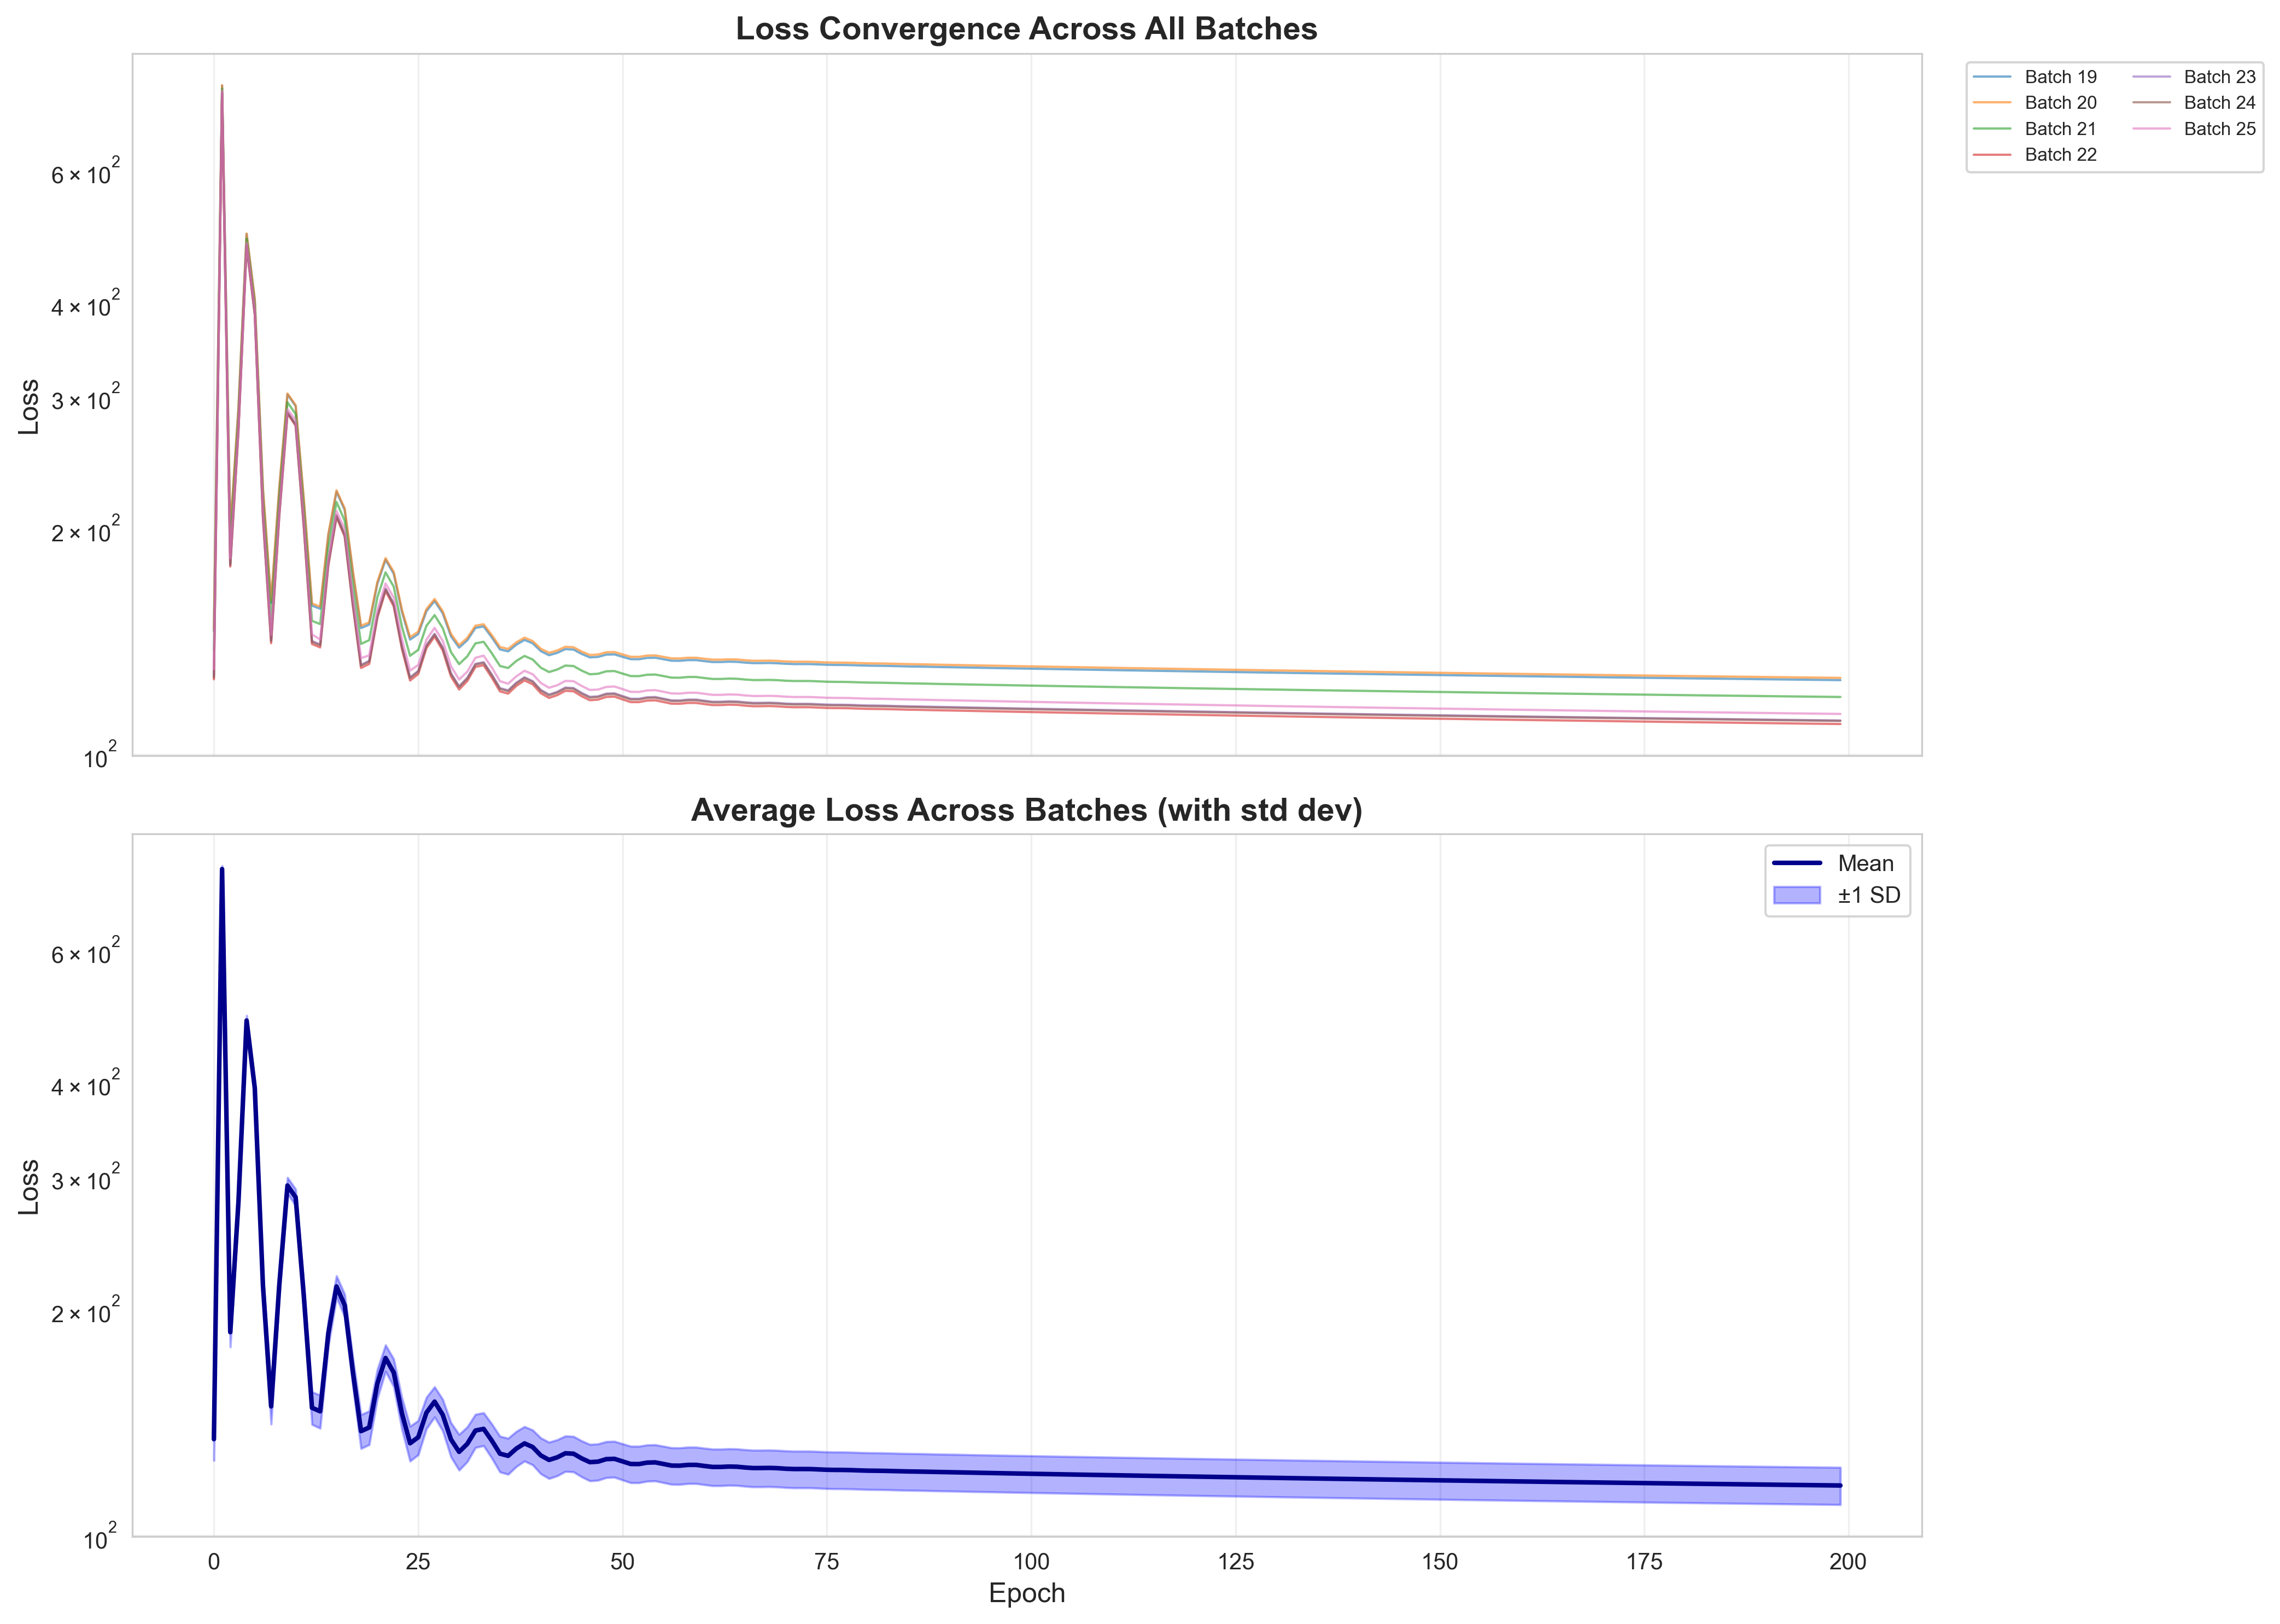

In [18]:
%run analyze_aou_batches.py

Number of signatures: 20
Number of diseases: 348

Searching for breast lump/mass diseases...
  Disease 257: 'Lump or mass in breast' -> Signature 0

Found 25 batch files
  Loading aou_model_batch_0_0_10000.pt...
    Phi shape: (21, 348, 52)
  Loading aou_model_batch_10_100000_110000.pt...
    Phi shape: (21, 348, 52)
  Loading aou_model_batch_11_110000_120000.pt...
    Phi shape: (21, 348, 52)
  Loading aou_model_batch_12_120000_130000.pt...
    Phi shape: (21, 348, 52)
  Loading aou_model_batch_13_130000_140000.pt...
    Phi shape: (21, 348, 52)
  Loading aou_model_batch_14_140000_150000.pt...
    Phi shape: (21, 348, 52)
  Loading aou_model_batch_15_150000_160000.pt...
    Phi shape: (21, 348, 52)
  Loading aou_model_batch_16_160000_170000.pt...
    Phi shape: (21, 348, 52)
  Loading aou_model_batch_17_170000_180000.pt...
    Phi shape: (21, 348, 52)
  Loading aou_model_batch_18_180000_190000.pt...
    Phi shape: (21, 348, 52)
  Loading aou_model_batch_19_190000_200000.pt...
    Phi 

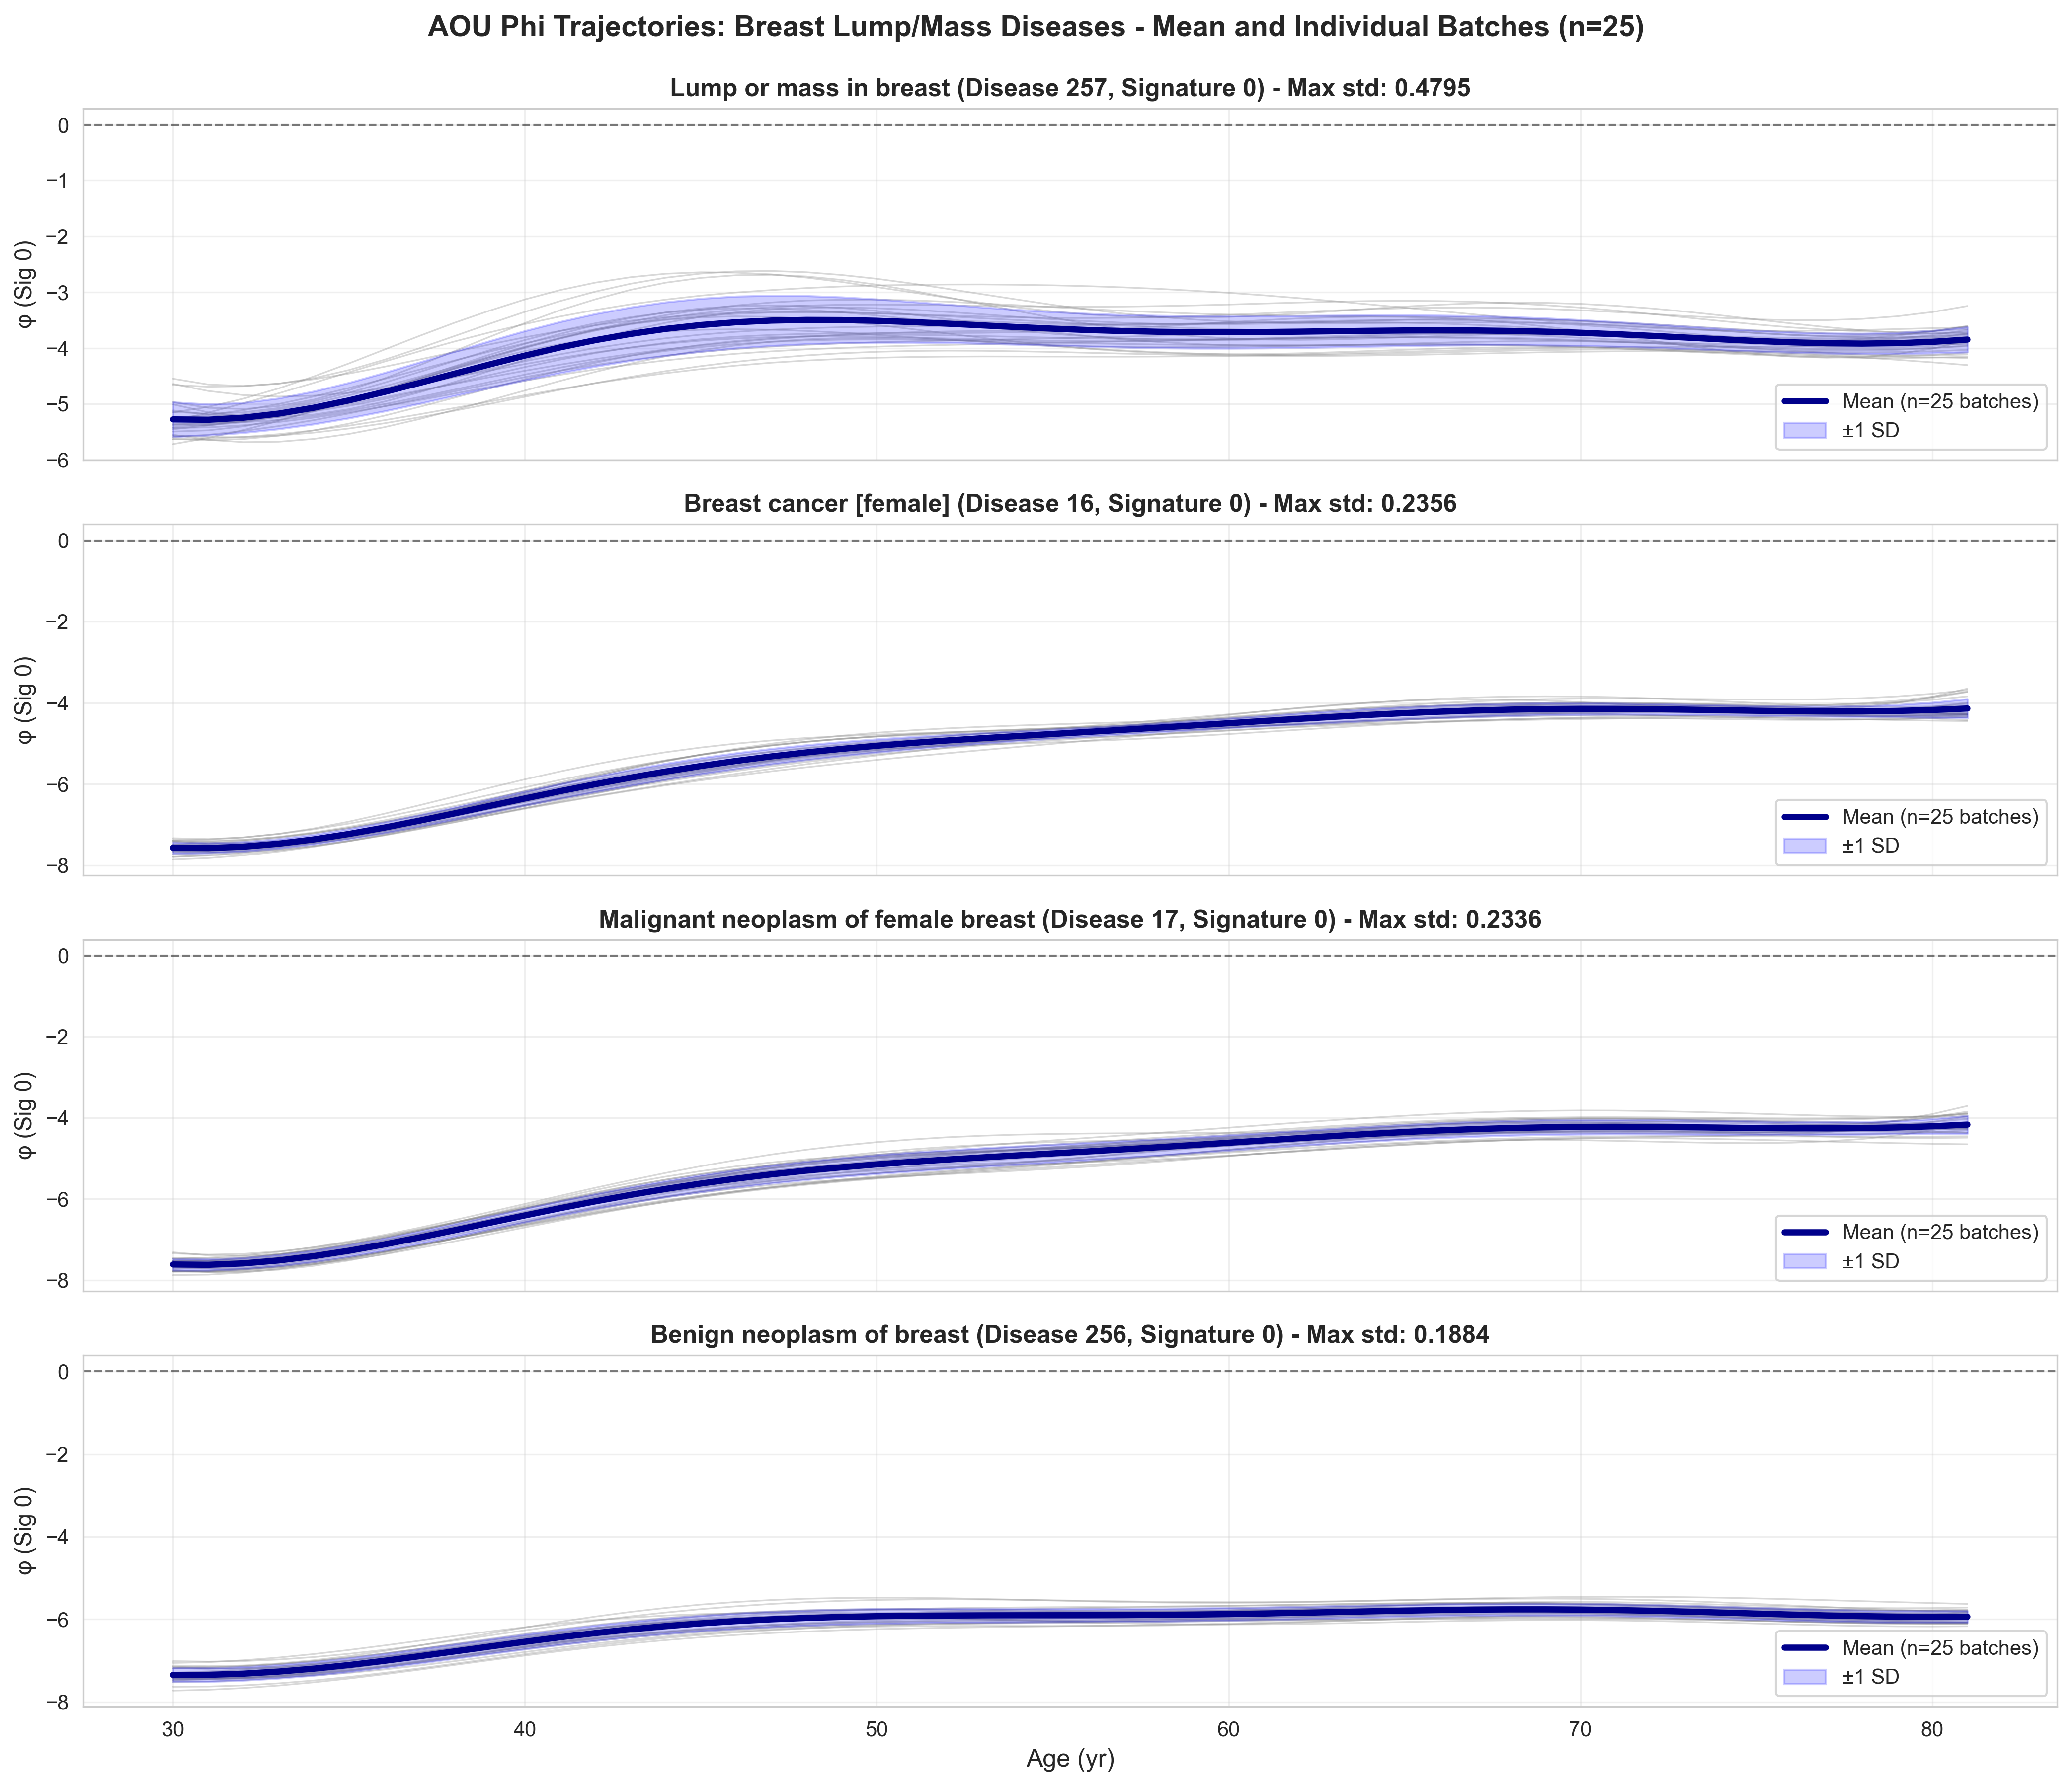


PHI STATISTICS
Phi shape: (21, 348, 52)
Phi range: [-21.9250, 0.1727]
Phi mean: -8.5308
Phi std (across batches): [0.0364, 0.5769]

Plotted diseases - phi statistics:
  Lump or mass in breast (D257, Sig0):
    φ mean=-3.9540, min=-5.2846, max=-3.4960
    Overall std=0.3107, Max std=0.4795
    Std by age range:
      Age 30-40: std=0.3274
      Age 40-50: std=0.4562
      Age 50-60: std=0.3198
      Age 60-70: std=0.2727
      Age 70-81: std=0.1975
  Breast cancer [female] (D16, Sig0):
    φ mean=-5.1872, min=-7.5725, max=-4.1394
    Overall std=0.1460, Max std=0.2356
    Std by age range:
      Age 30-40: std=0.1324
      Age 40-50: std=0.1875
      Age 50-60: std=0.1249
      Age 60-70: std=0.1427
      Age 70-81: std=0.1347
  Malignant neoplasm of female breast (D17, Sig0):
    φ mean=-5.2596, min=-7.6228, max=-4.1639
    Overall std=0.1842, Max std=0.2336
    Std by age range:
      Age 30-40: std=0.1460
      Age 40-50: std=0.2012
      Age 50-60: std=0.2196
      Age 60-70: std=0

In [27]:
%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/plot_aou_phi_sample.py

Number of signatures: 20
Number of diseases: 348

Found 25 batch files
  Loading aou_model_batch_0_0_10000.pt...
  Loading aou_model_batch_10_100000_110000.pt...
  Loading aou_model_batch_11_110000_120000.pt...
  Loading aou_model_batch_12_120000_130000.pt...
  Loading aou_model_batch_13_130000_140000.pt...
  Loading aou_model_batch_14_140000_150000.pt...
  Loading aou_model_batch_15_150000_160000.pt...
  Loading aou_model_batch_16_160000_170000.pt...
  Loading aou_model_batch_17_170000_180000.pt...
  Loading aou_model_batch_18_180000_190000.pt...
  Loading aou_model_batch_19_190000_200000.pt...
  Loading aou_model_batch_1_10000_20000.pt...
  Loading aou_model_batch_20_200000_210000.pt...
  Loading aou_model_batch_21_210000_220000.pt...
  Loading aou_model_batch_22_220000_230000.pt...
  Loading aou_model_batch_23_230000_240000.pt...
  Loading aou_model_batch_24_240000_243303.pt...
  Loading aou_model_batch_2_20000_30000.pt...
  Loading aou_model_batch_3_30000_40000.pt...
  Loading aou_

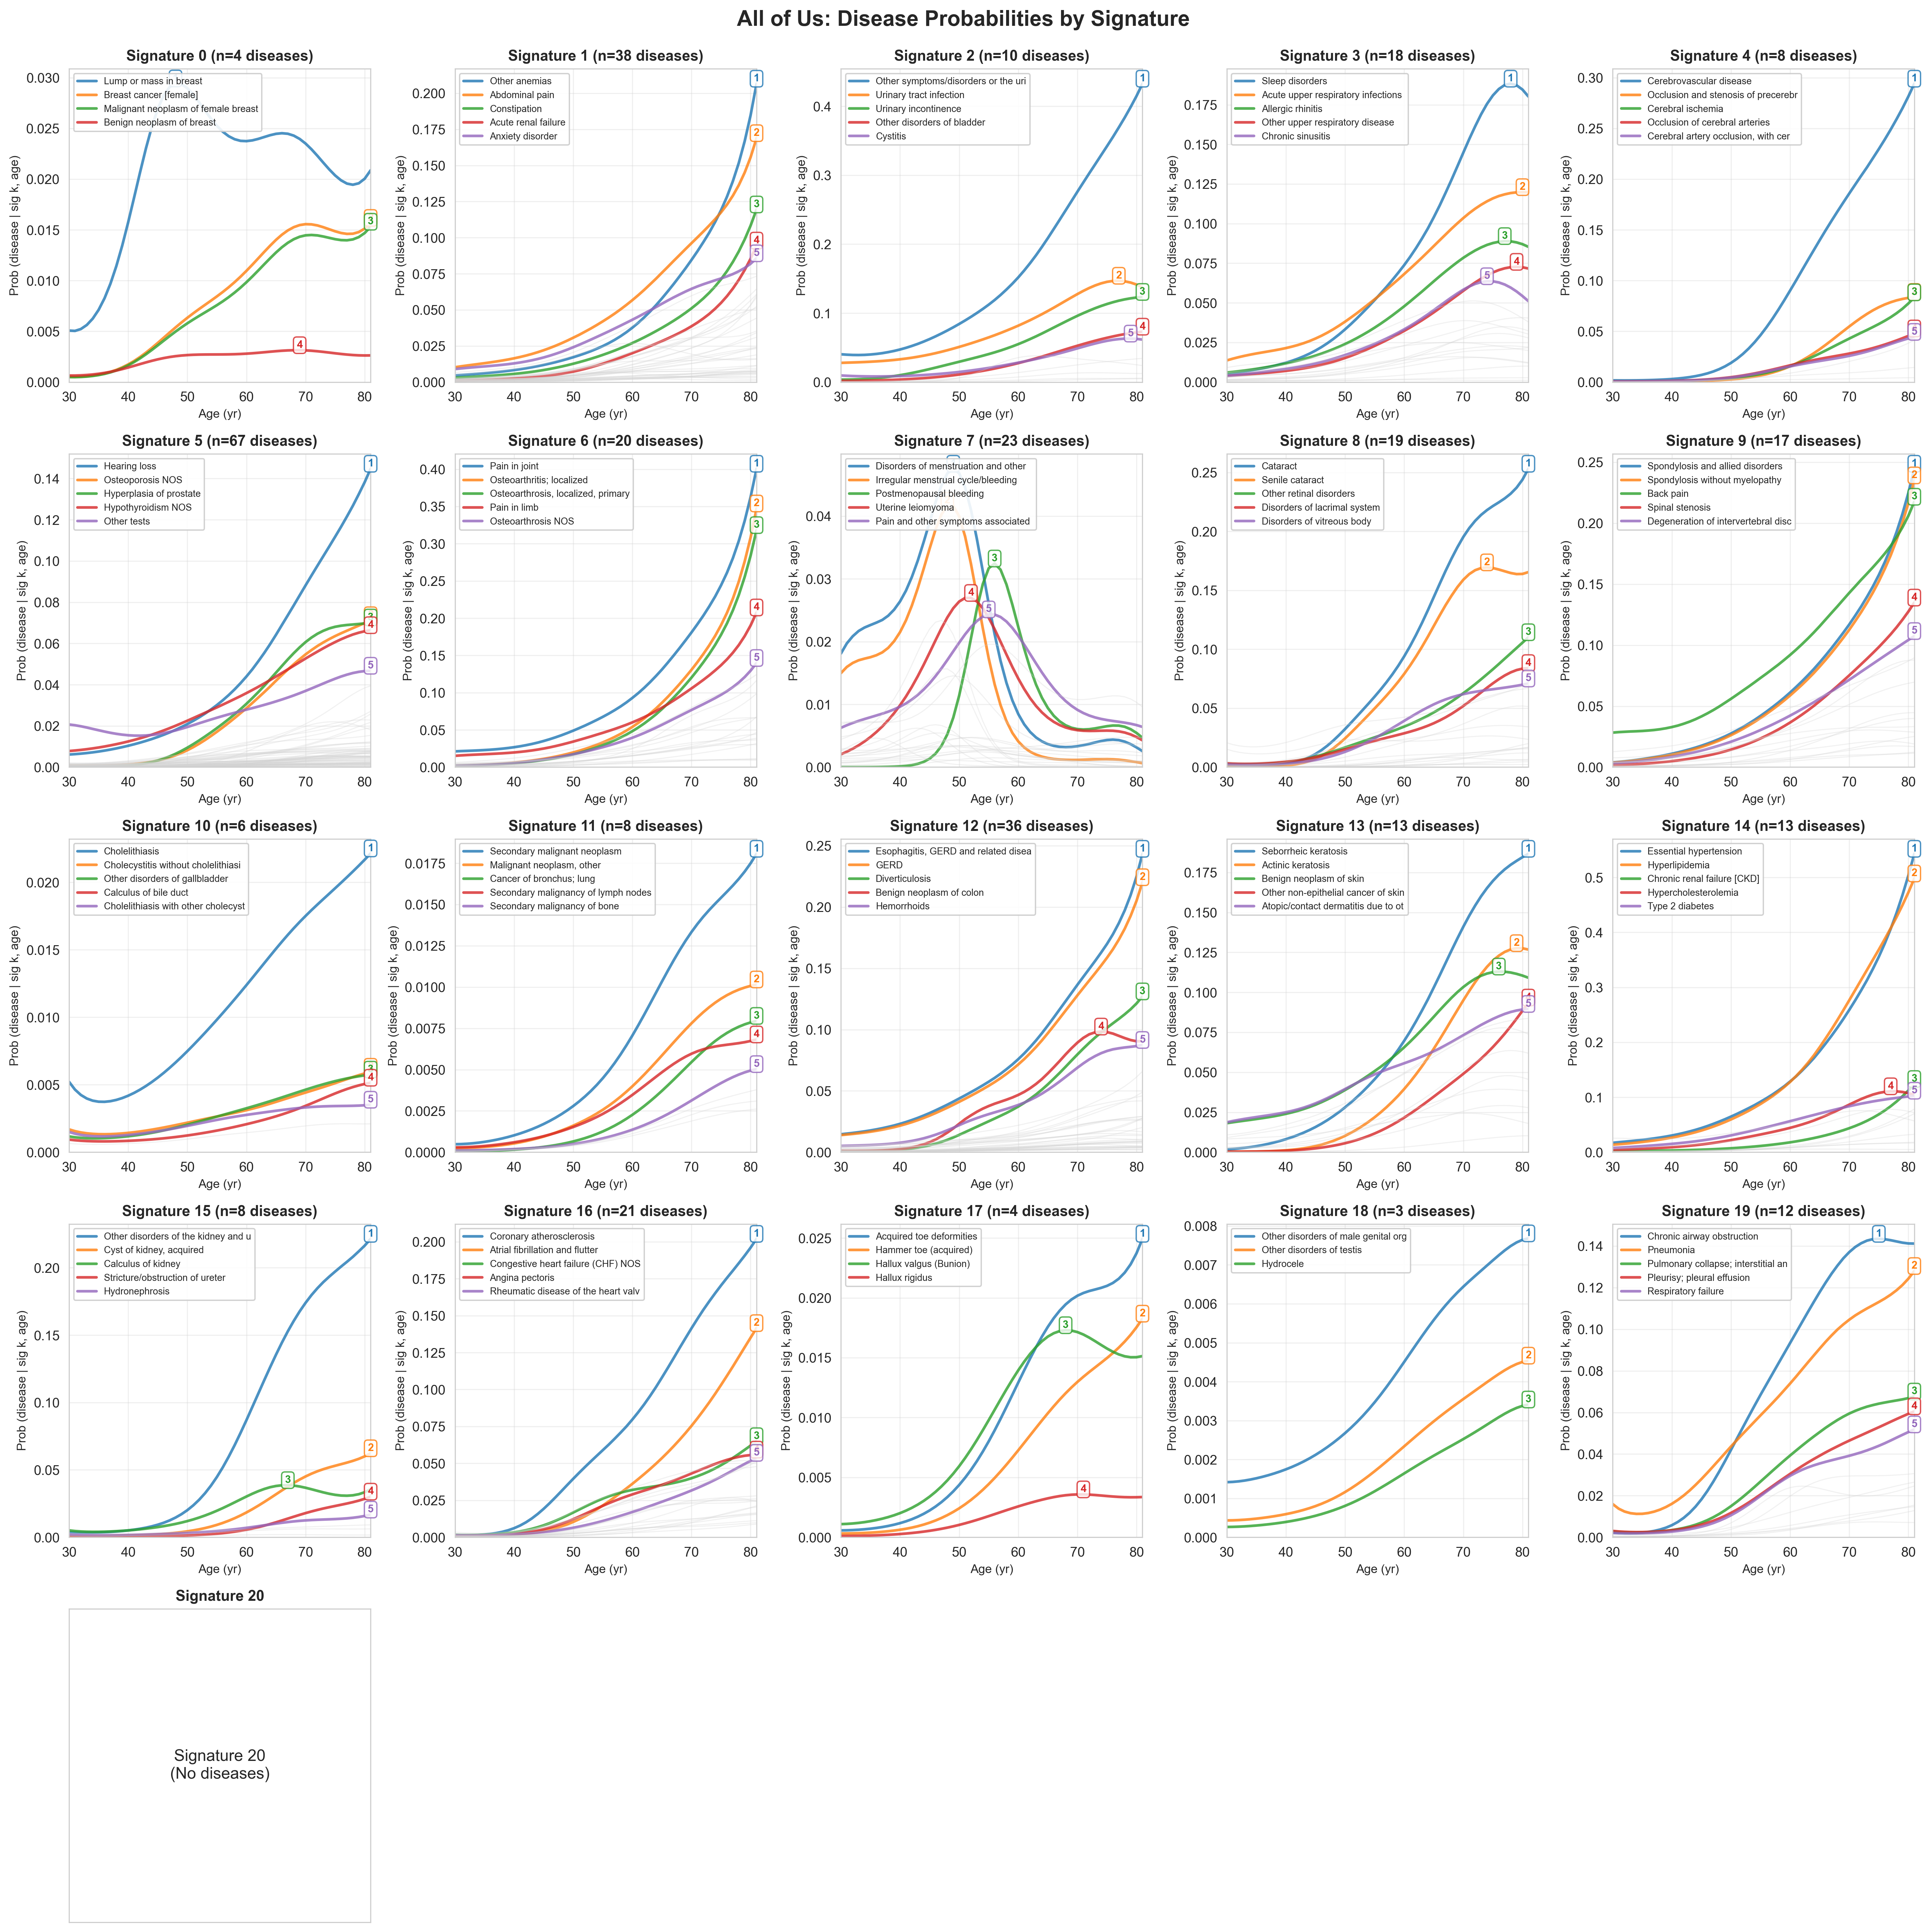


SIGNATURE SUMMARY
Signature 0: 4 diseases
  Top diseases:
    Lump or mass in breast: max prob = 0.029428
    Breast cancer [female]: max prob = 0.015682
    Malignant neoplasm of female breast: max prob = 0.015309
    Benign neoplasm of breast: max prob = 0.003141
Signature 1: 38 diseases
  Top diseases:
    Other anemias: max prob = 0.206598
    Abdominal pain: max prob = 0.168872
    Constipation: max prob = 0.119496
    Acute renal failure: max prob = 0.094505
    Anxiety disorder: max prob = 0.085695
Signature 2: 10 diseases
  Top diseases:
    Other symptoms/disorders or the urinary system: max prob = 0.432728
    Urinary tract infection: max prob = 0.146930
    Urinary incontinence: max prob = 0.123471
    Other disorders of bladder: max prob = 0.073084
    Cystitis: max prob = 0.063057
Signature 3: 18 diseases
  Top diseases:
    Sleep disorders: max prob = 0.188295
    Acute upper respiratory infections of multiple or : max prob = 0.119846
    Allergic rhinitis: max prob = 0.

In [29]:


%run /Users/sarahurbut/aladynoulli2/pyScripts/dec_6_revision/new_notebooks/plot_aou_all_signatures.py